In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scanpy.external as sce

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, color_map = 'viridis_r')

/home/teach2_pkuhpc/gpfs1/xuzk/Anaconda/envs/py_3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [3]:
T_file = 'write_LCA/m_LCA1-2_T.h5ad'
T_file_v2 = 'write_LCA/m_LCA1-2_T_v2.h5ad' # mt, ribosomal, cell-cycle genes removed, raw: unregressed and unscaled, unwanted cells excluded
T_file_v3 = 'write_LCA/m_LCA1-2_T_v3.h5ad' # regressed and scaled

# identifying subsets of T cells

In [4]:
adata_T=sc.read_h5ad(T_file_v2)

In [28]:
adata_T

AnnData object with n_obs × n_vars = 1685 × 5455
    obs: 'Barcode', 'Biological replicate', 'Library', 'Most_likely_Immgen_cell_type', 'Major_cell_type', 'Minor_subset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'label_singleR', 'leiden', 'lymphoid', 'label_rough'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Biological replicate_colors', 'Library_colors', 'Major_cell_type_colors', 'hvg', 'label_singleR_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [29]:
adata_T = adata_T.raw.to_adata()

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
False    23222
True      4983
Name: highly_variable, dtype: int64


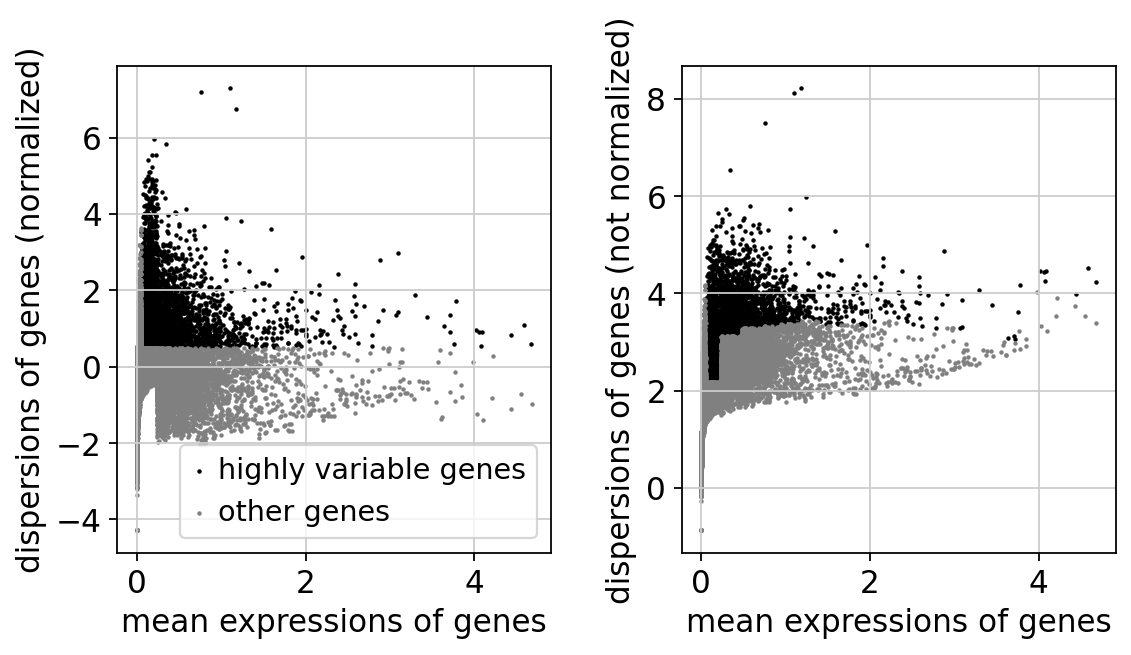

In [30]:
adata_T.uns['log1p']={'base': None}
sc.pp.highly_variable_genes(adata_T, min_mean=0.05, max_mean=8, min_disp=0.5) 
print(adata_T.var['highly_variable'].value_counts(normalize=False))
sc.pl.highly_variable_genes(adata_T)

### remove mt, ribosomal, cell-cycle genes

In [31]:
## cell cycle genes
s_genes = open("write_LCA/mouse_S.txt").read().splitlines()
g2m_genes = open("write_LCA/mouse_G2M.txt").read().splitlines()
# remove cell cycle genes
all_genes = list(adata_T.var_names)
retained_genes = [x for x in all_genes if x not in s_genes]
retained_genes = [x for x in retained_genes if x not in g2m_genes]

In [32]:
## ribosomal genes
rib_genes = [x for x in all_genes if (x.startswith('Rps') or x.startswith('Rpl'))]
mrib_genes = [x for x in all_genes if (x.startswith('Mrps') or x.startswith('Mrpl'))]
## remove ribosomal genes
retained_genes = [x for x in retained_genes if x not in rib_genes]
retained_genes = [x for x in retained_genes if x not in mrib_genes]

In [33]:
adata_T = adata_T[:,retained_genes]
adata_T
## 536 genes removed

View of AnnData object with n_obs × n_vars = 1685 × 27669
    obs: 'Barcode', 'Biological replicate', 'Library', 'Most_likely_Immgen_cell_type', 'Major_cell_type', 'Minor_subset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'label_singleR', 'leiden', 'lymphoid', 'label_rough'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Biological replicate_colors', 'Library_colors', 'Major_cell_type_colors', 'hvg', 'label_singleR_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'

In [34]:
## remove mitochondrial genes
adata_T = adata_T[:,adata_T.var['mt']==False]
adata_T
## 13 genes removed

View of AnnData object with n_obs × n_vars = 1685 × 27656
    obs: 'Barcode', 'Biological replicate', 'Library', 'Most_likely_Immgen_cell_type', 'Major_cell_type', 'Minor_subset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'label_singleR', 'leiden', 'lymphoid', 'label_rough'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Biological replicate_colors', 'Library_colors', 'Major_cell_type_colors', 'hvg', 'label_singleR_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'

In [35]:
adata_T.var['highly_variable'].value_counts(normalize=False)
# 75 HVGs removed

False    22748
True      4908
Name: highly_variable, dtype: int64

In [36]:
adata_T.raw = adata_T
adata_T = adata_T[:, adata_T.var.highly_variable]

In [37]:
sc.pp.regress_out(adata_T, ['total_counts','pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:14)


In [38]:
sc.pp.scale(adata_T, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


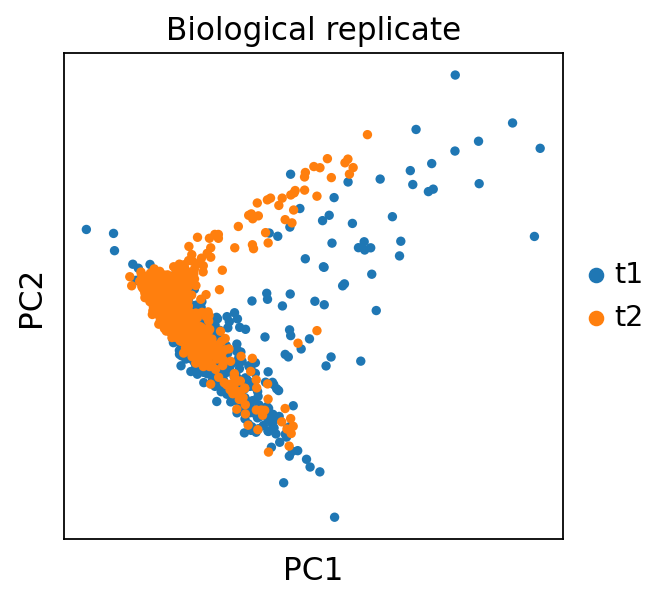

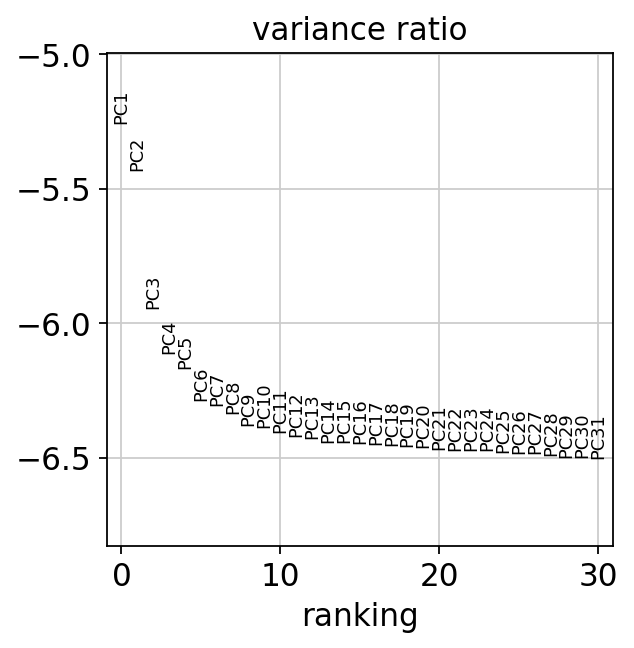

In [39]:
sc.tl.pca(adata_T, svd_solver='arpack')
sc.pl.pca(adata_T, color='Biological replicate')
sc.pl.pca_variance_ratio(adata_T, log=True)

In [40]:
sc.pp.neighbors(adata_T, n_pcs=17)
sc.tl.umap(adata_T)

computing neighbors
    using 'X_pca' with n_pcs = 17
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


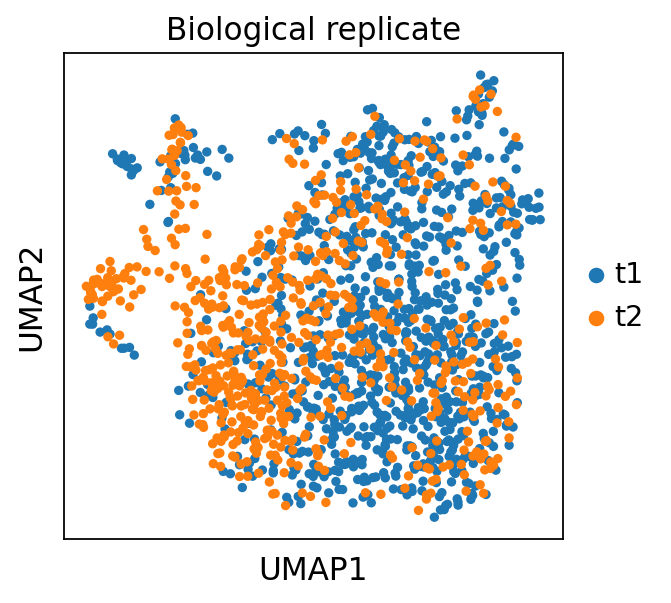

In [41]:
sc.pl.umap(adata_T, color='Biological replicate')

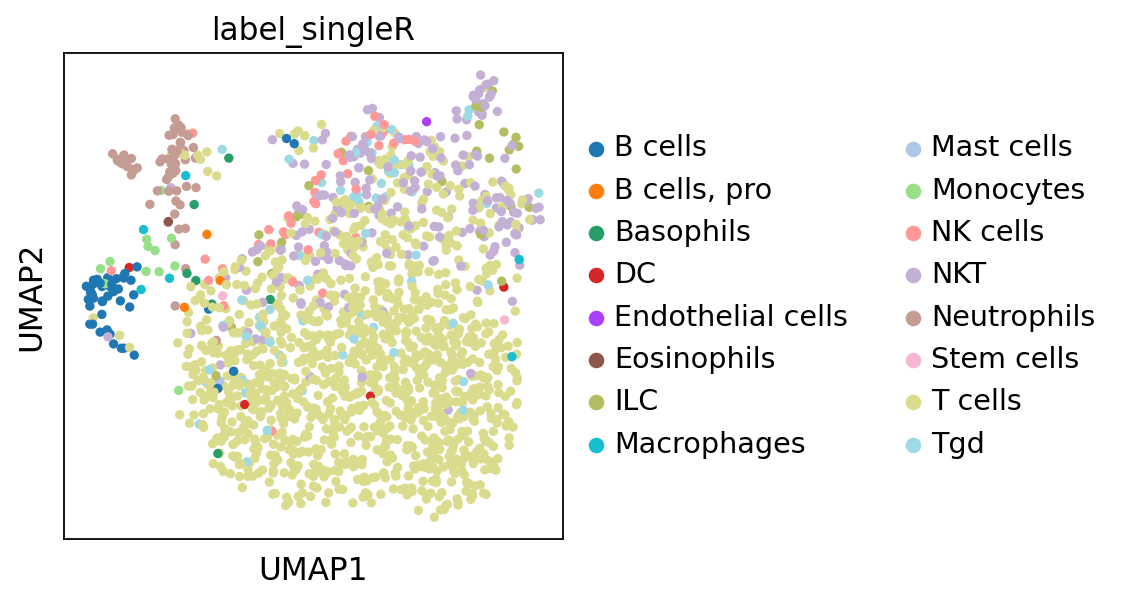

In [42]:
sc.pl.umap(adata_T, color='label_singleR')

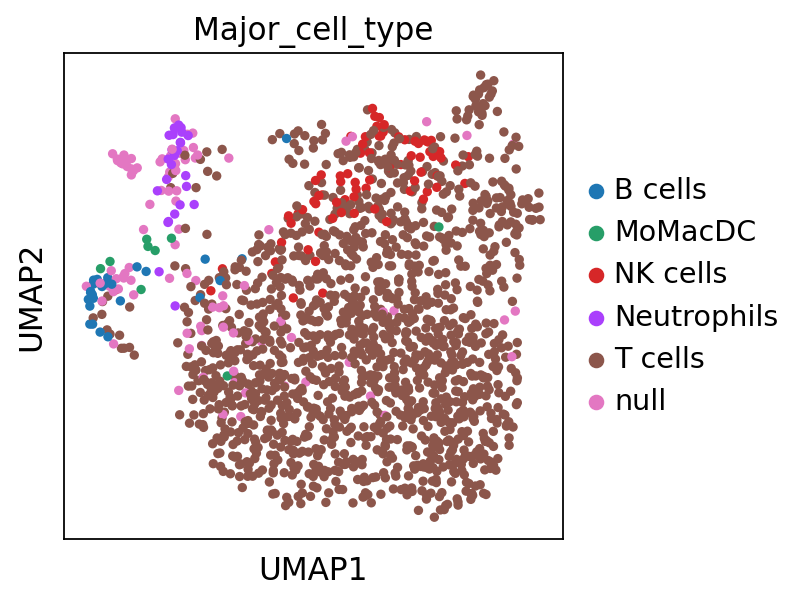

In [43]:
sc.pl.umap(adata_T, color='Major_cell_type')

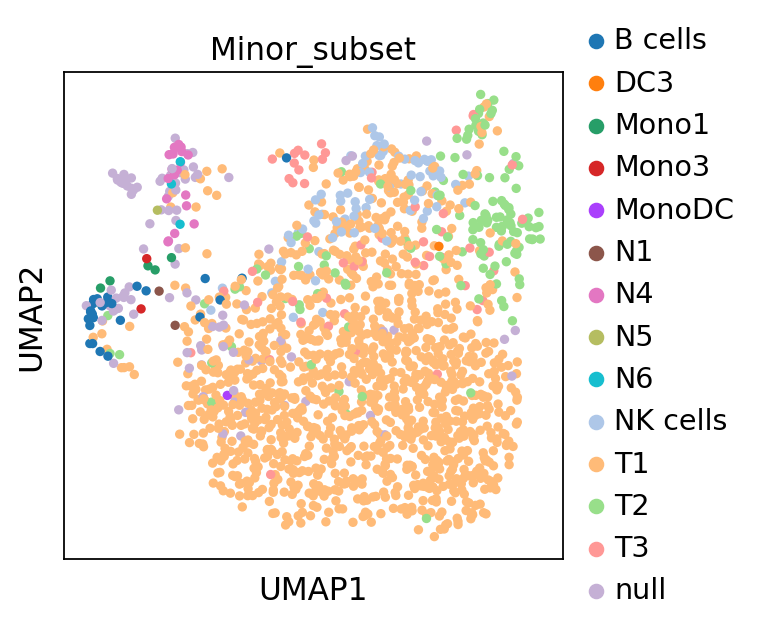

In [44]:
sc.pl.umap(adata_T, color='Minor_subset')

In [45]:
sc.tl.leiden(adata_T, resolution = 1)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


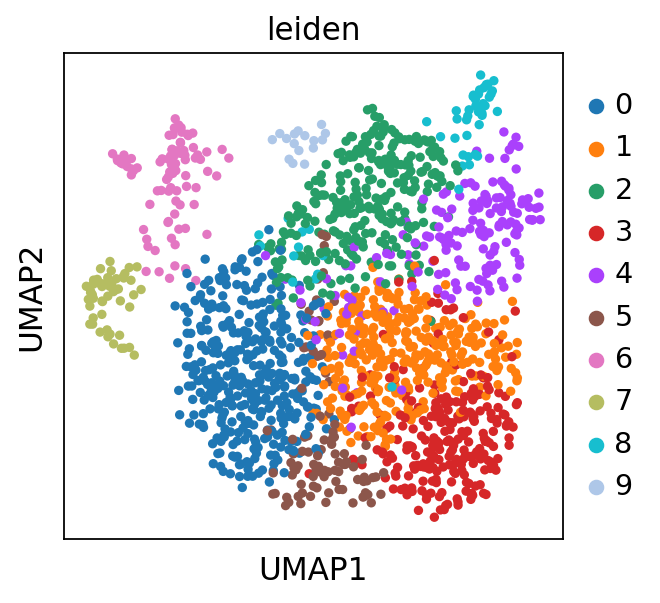

In [46]:
sc.pl.umap(adata_T, color='leiden')

6, 7 可能分别是neutrophil和B cell，弃之

In [47]:
cluster2label = {
     '6':'n','7':'n'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata_T.obs['T'] = adata_T.obs['leiden'].map(cluster2label).astype('category')
# exclude unwanted cells
adata_T = adata_T[adata_T.obs['T']!='n',:]

# clustering and DEG detection

In [48]:
sc.tl.leiden(adata_T, resolution = 3)

running Leiden clustering


Trying to set attribute `.obs` of view, copying.


    finished: found 36 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


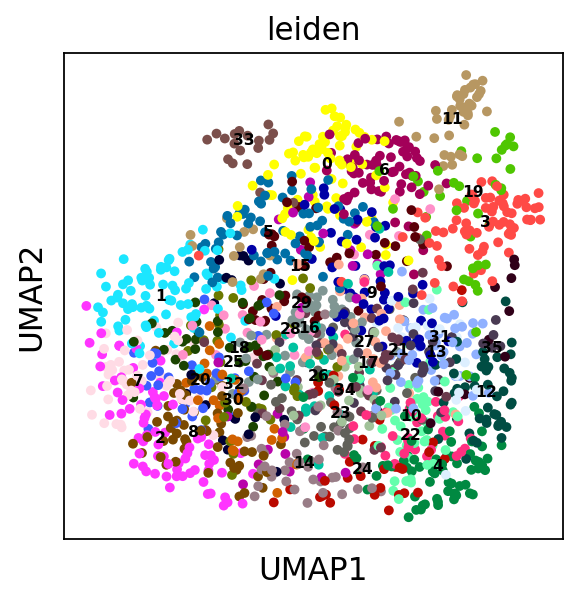

In [49]:
sc.pl.umap(adata_T, color='leiden',legend_loc = 'on data', legend_fontsize=7)

In [ ]:
sc.tl.rank_genes_groups(adata_T, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_T, n_genes=25, sharey=False)

# define subclusters

In [6]:
adata=sc.read_h5ad(T_file_v3)

In [61]:
### calculate scaled counts of all genes for visualization
adata=adata_T.raw.to_adata()
sc.pp.regress_out(adata, ['total_counts','pct_counts_mt'])# 这一步极慢，因为是对于全部的基因操作
sc.pp.scale(adata, max_value = 10)


regressing out ['total_counts', 'pct_counts_mt']
    finished (0:01:05)


In [71]:
adata.obs['leiden']=adata_T.obs['leiden']

In [72]:
sc.tl.dendrogram(adata,groupby='leiden')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


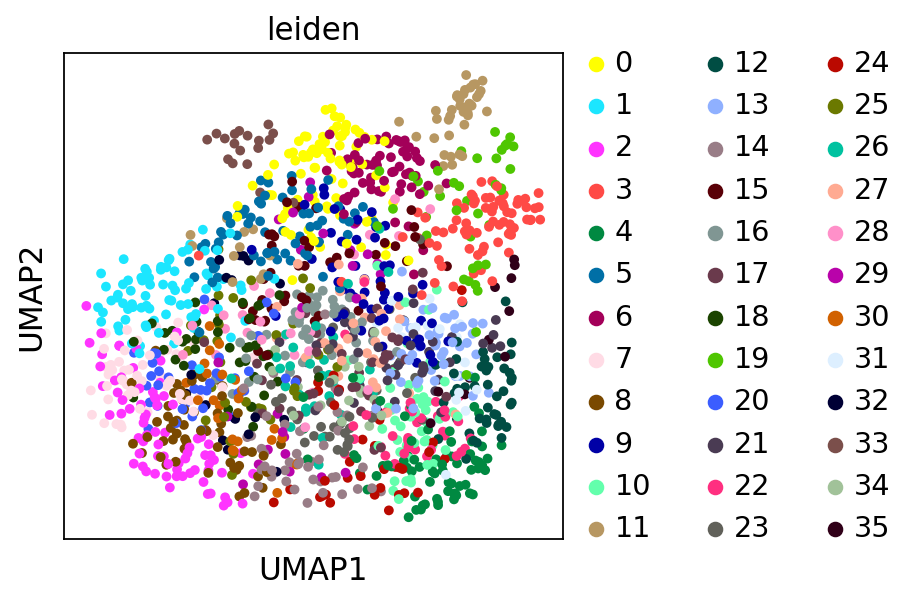

In [73]:
sc.pl.umap(adata, color='leiden')

In [8]:
# markers for cell lineages
marker_genes_dict = {
    'CD4': ['Cd4','Il7r'],
    'CD8': ['Cd8a','Cd8b1'],
    'naive markers': ['Tcf7','Sell','Lef1','Ccr7'],
    'exhausted/inhbitory': ['Lag3','Tigit','Pdcd1','Havcr2','Ctla4'],
    'cytotoxic/effector': ['Il2','Gzma','Prf1','Gzmb','Gzmk','Ifng','Nkg7'],
    'Treg': ['Il2ra','Foxp3','Ikzf2'],
    'Tfh': ['Maf','Cxcl13','Cxcr5','Pdcd1'],
    'Th17':['Irf4','Crem','Nr4a2'],
    'Th1':['Stat4','Il12rb2','Ifng'],
    'Th2':['Gata3','Stat6','Il4']
}

categories: 0, 1, 2, etc.
var_group_labels: CD4, CD8, naive markers, etc.


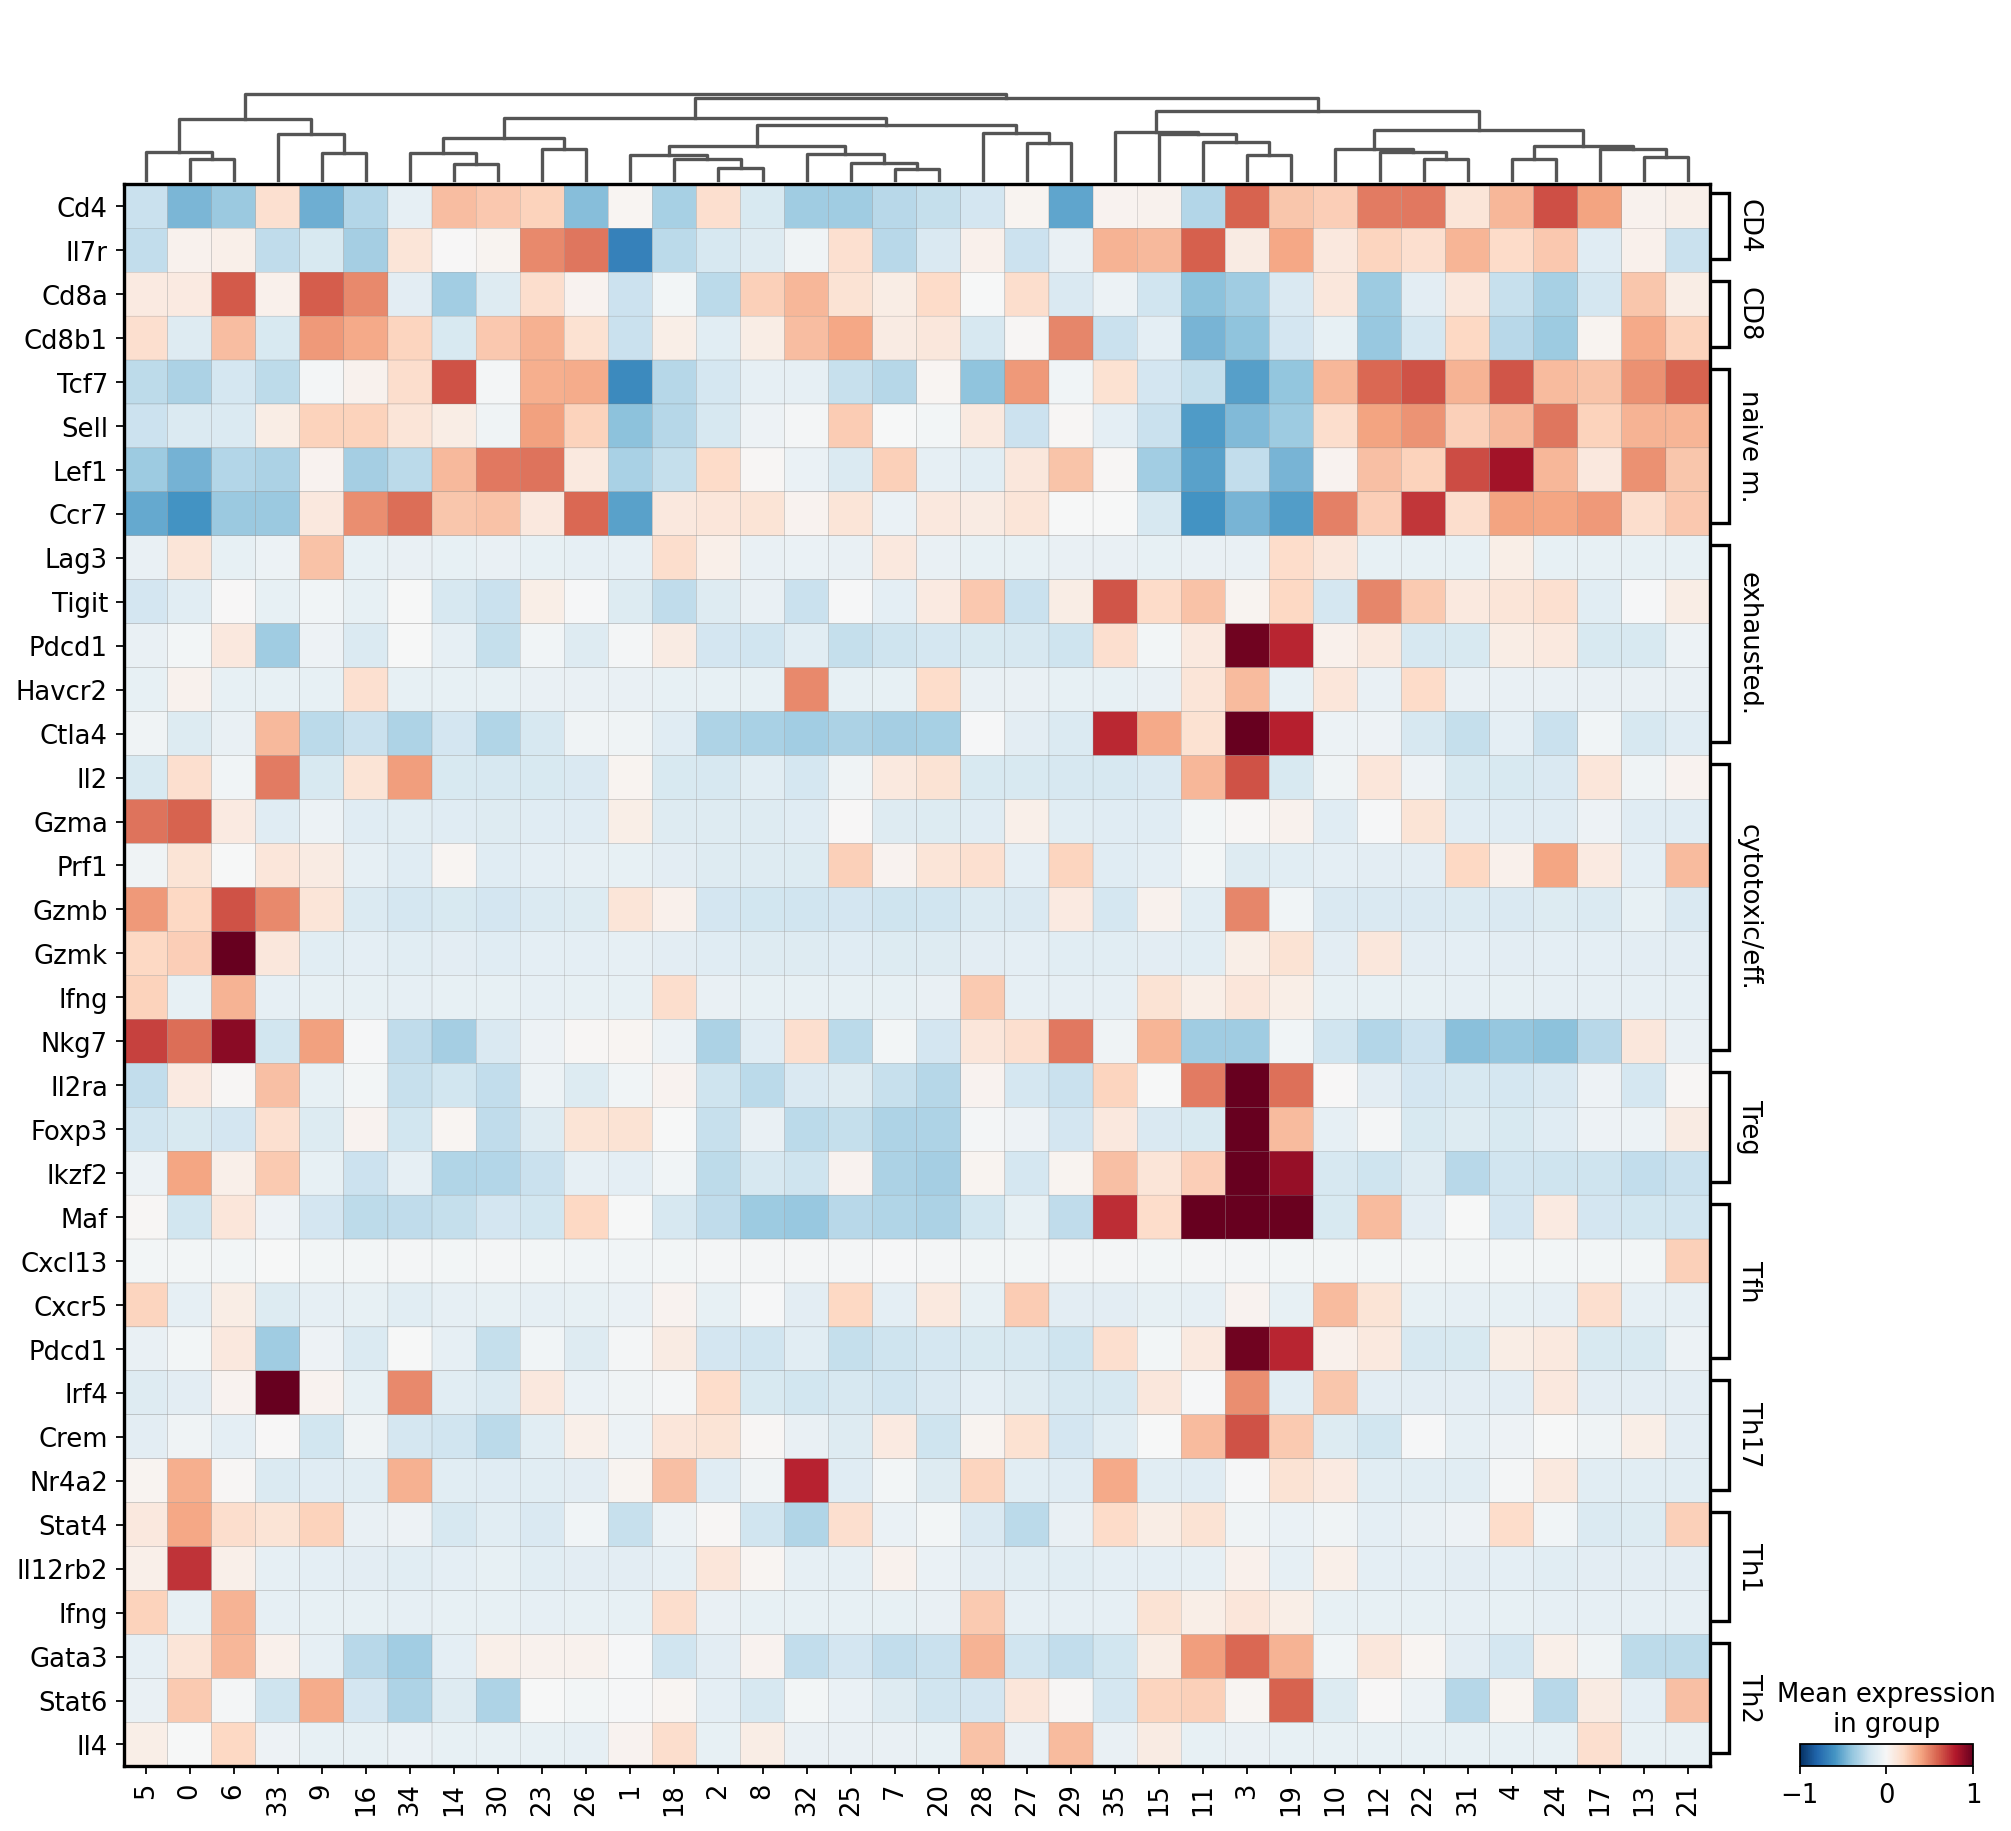

In [75]:
## matrixplot of normalized data
sc.pl.matrixplot(adata, var_names=marker_genes_dict,groupby='leiden', dendrogram=True, use_raw=False,swap_axes=True,cmap='RdBu_r', vmax=1, vmin=-1)

CD8+ cytotoxic T: 5, 0, 6, 9, 33

CD8+ naive T: 16, 26, 13, 21, 7

CD4+/CD8+ naive T: 34, 30, 23, 31

CD4+ naive T: 14, 10, 12, 22, 4, 24, 17

undefined T: 1, 18, 25, 28

CD4+ undefined T: 2

CD8+ undefined T: 8, 32, 20, 27, 29

CD4+ exhausted Tfh&Treg: 35, 15, 11, 3, 19




In [50]:
# create a dictionary to map cluster to subtype annotation label
cluster2annotation = {
     '0': 'm-CD8+ cytotoxic T',
    '1': 'm-undefined T', 
    '2':'m-CD4+ undefined T',
    '3':'m-CD4+ exhausted Tfh&Treg',
    '4': 'm-CD4+ naive T',
    '5':'m-CD8+ cytotoxic T',
    '6':'m-CD8+ cytotoxic T',
    '7':'m-CD8+ naive T',
    '8':'m-CD8+ undefined T',
    '9':'m-CD8+ cytotoxic T',
    '10':'m-CD4+ naive T',
    '11':'m-CD4+ exhausted Tfh&Treg',
    '12':'m-CD4+ naive T',
    '13':'m-CD8+ naive T',
    '14':'m-CD4+ naive T',
    '15':'m-CD4+ exhausted Tfh&Treg',
    '16':'m-CD8+ naive T',
    '17':'m-CD4+ naive T',
    '18':'m-undefined T',
    '19':'m-CD4+ exhausted Tfh&Treg',
    '20':'m-CD8+ undefined T',
    '21':'m-CD8+ naive T',
    '22':'m-CD4+ naive T',
    '23':'m-CD4+/CD8+ naive T',
    '24':'m-CD4+ naive T',
    '25':'m-undefined T',
    '26':'m-CD8+ naive T',
    '27':'m-CD8+ undefined T',
    '28':'m-undefined T',
    '29':'m-CD8+ undefined T',
    '30':'m-CD4+/CD8+ naive T',
    '31':'m-CD4+/CD8+ naive T',
    '32':'m-CD8+ undefined T',
    '33':'m-CD8+ cytotoxic T',
    '34':'m-CD4+/CD8+ naive T',
    '35':'m-CD4+ exhausted Tfh&Treg'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata_T.obs['label_subtype'] = adata_T.obs['leiden'].map(cluster2annotation).astype('category')

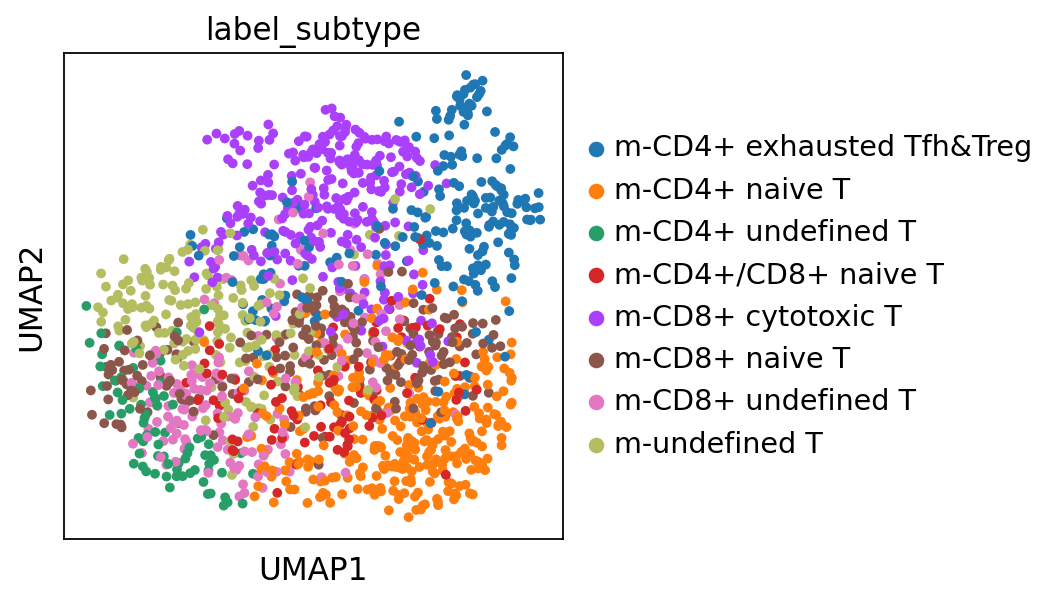

In [51]:
sc.pl.umap(adata_T, color=['label_subtype'])

In [9]:
# markers for cell lineages
marker_genes_dict_1 = {
    'CD4': ['Cd4','Il7r'],
    'CD8': ['Cd8a','Cd8b1'],
    'naive markers': ['Tcf7','Sell','Lef1','Ccr7'],
    'TEM/TRM':['Ccr5','Ccr3','Il7r'],
    'exhausted/inhbitory': ['Lag3','Tigit','Pdcd1','Havcr2','Ctla4'],
    'cytotoxic/effector': ['Il2','Gzma','Prf1','Gzmb','Gzmk','Ifng','Nkg7'],
    'Treg': ['Il2ra','Foxp3','Ikzf2'],
    'Tfh': ['Maf','Cxcl13','Cxcr5','Pdcd1'],
    'Th17':['Stat3','Rorc','Il17a','Irf4','Crem','Nr4a2'],
    'Th1':['Stat1','Tbx21','Stat4','Il12rb2','Ifng'],
    'Th2':['Gata3','Stat6','Il4','Il5','Il13'],
    'Th9':['Il9','Il10','Ifng']
}

categories: 0, 1, 2, etc.
var_group_labels: CD4, CD8, naive markers, etc.


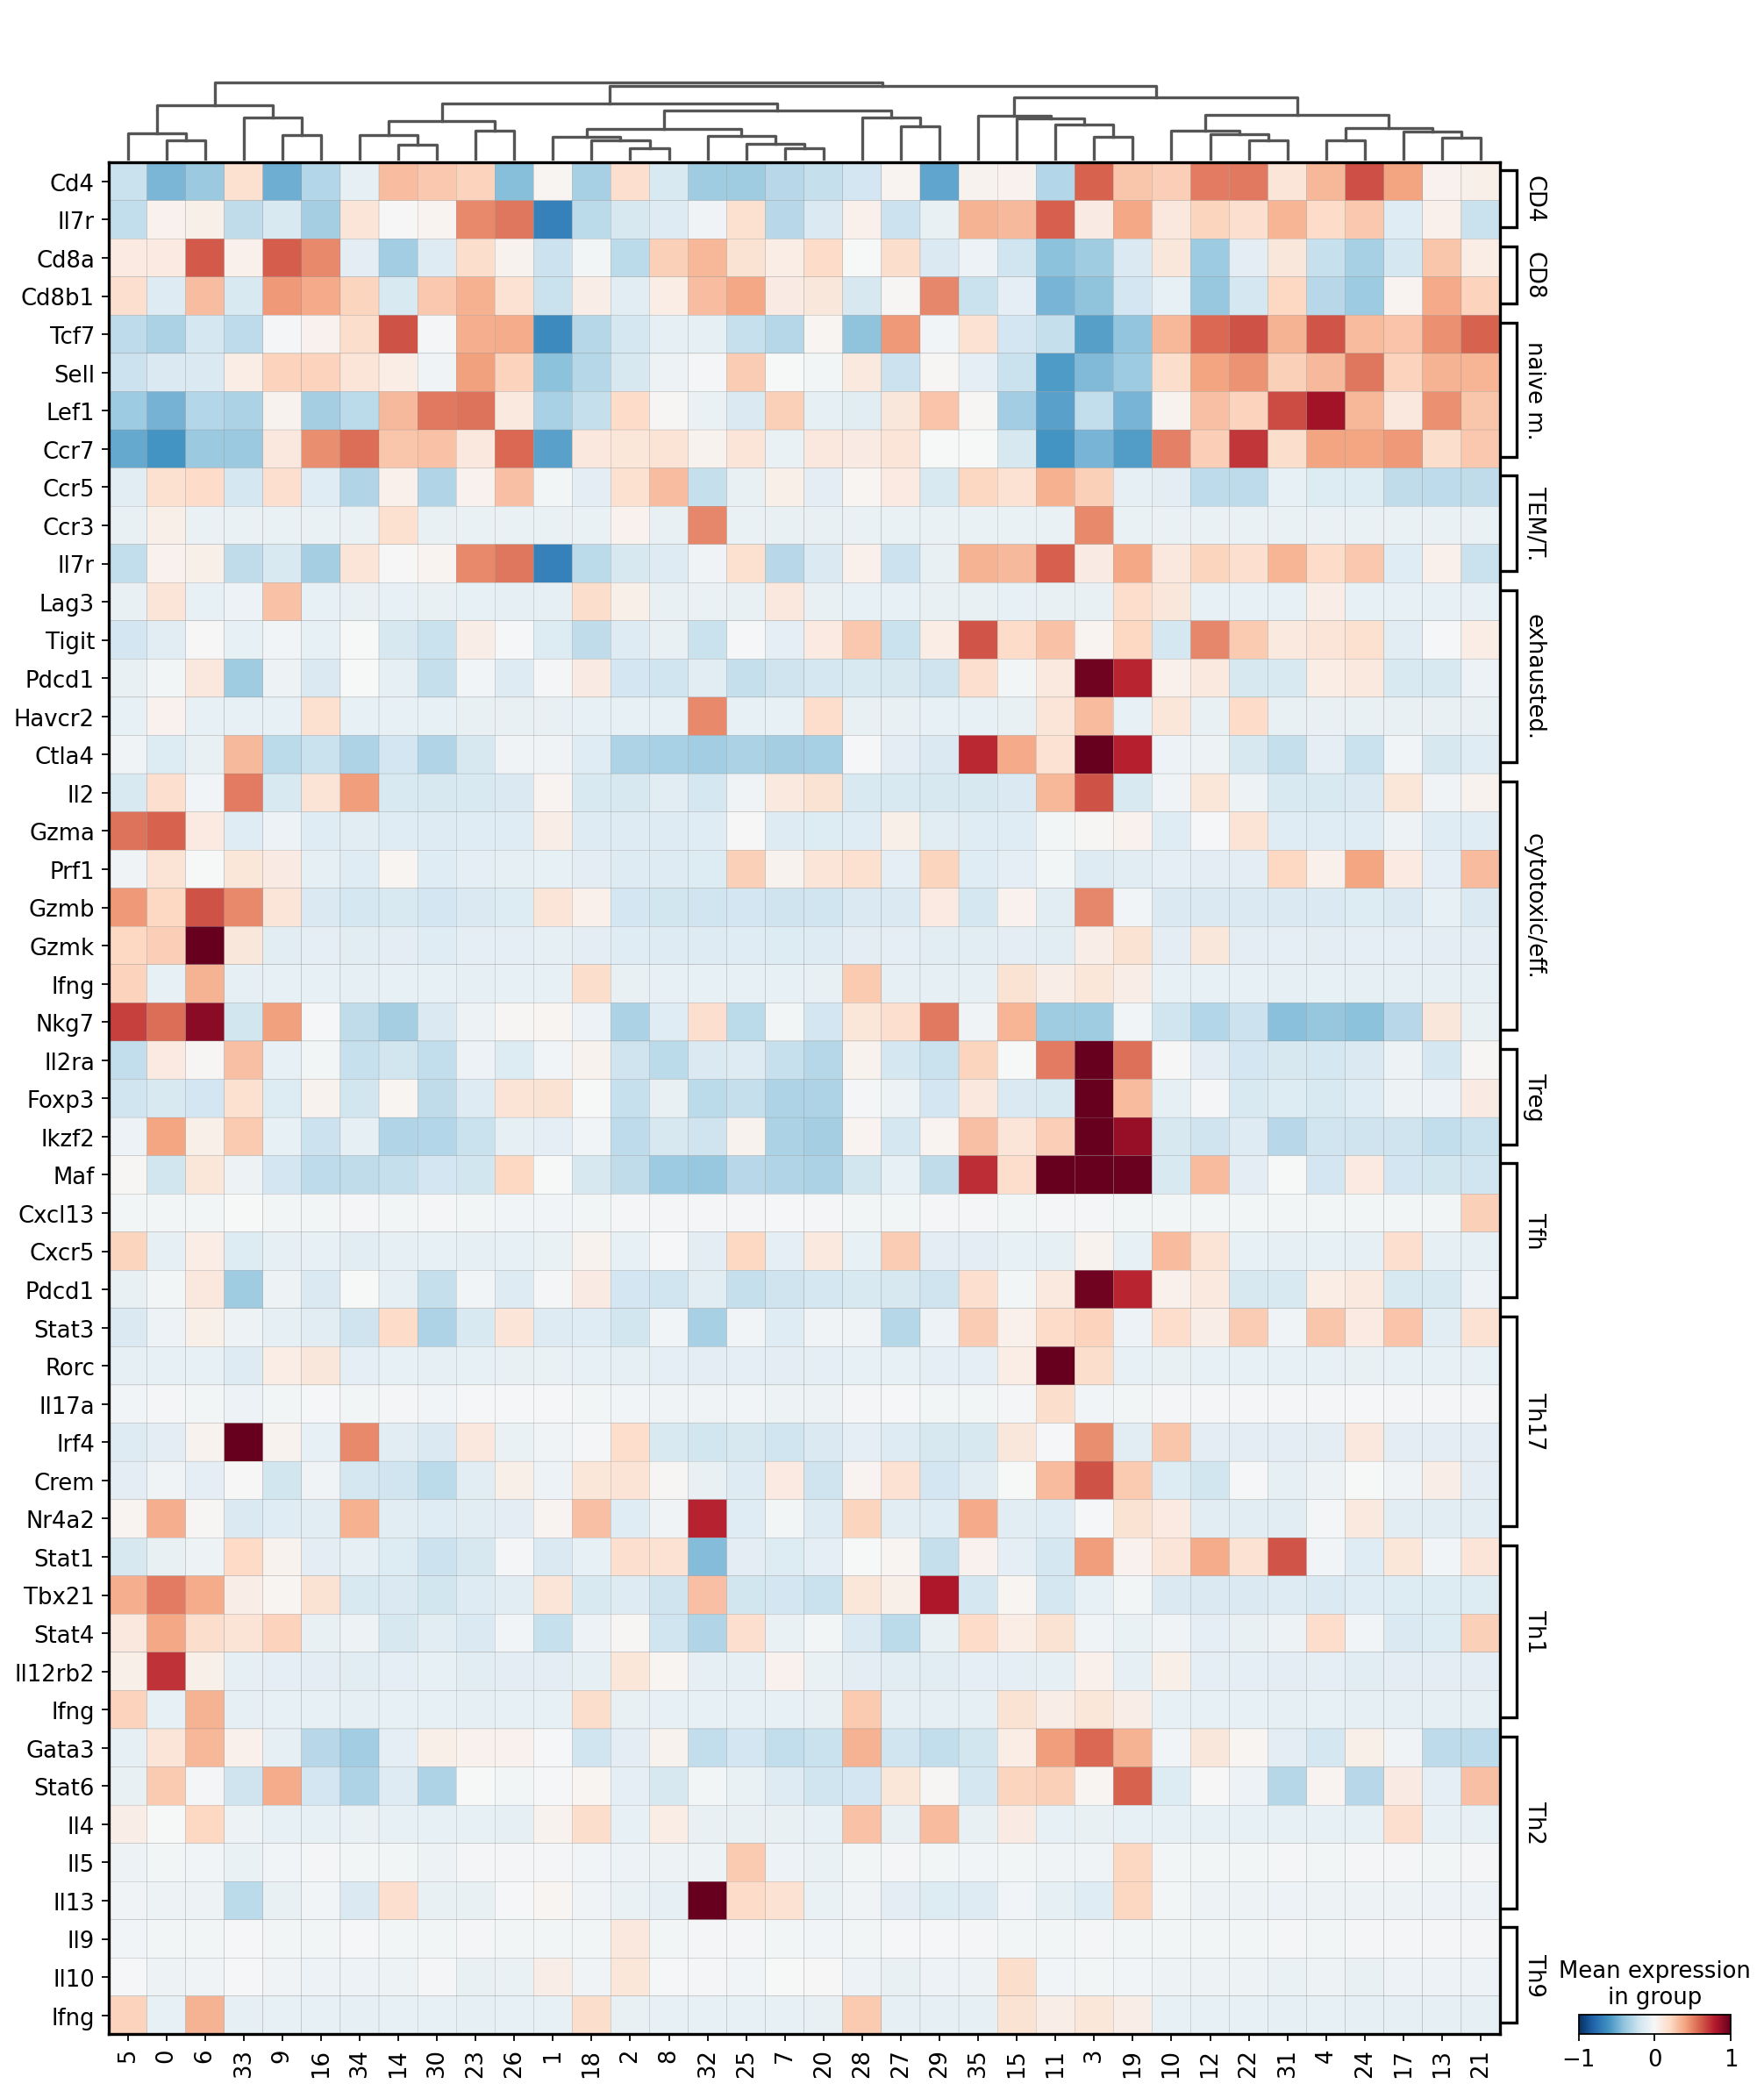

In [10]:
## matrixplot of normalized data
sc.pl.matrixplot(adata, var_names=marker_genes_dict_1,groupby='leiden', dendrogram=True, use_raw=False,swap_axes=True,cmap='RdBu_r', vmax=1, vmin=-1)

更细的分类：

CD8+ cytotoxic T: 5, 0, 6, 9

CD4+ cytotoxic T: 33

CD8+ naive T: 16, 26, 13, 21, 7

CD4+/CD8+ naive T: 34, 30, 23, 31

CD4+ naive T: 14, 10, 12, 22, 4, 24, 17

undefined T: 1, 18

Th9-like: 2

CD8+ Th2-like: 20, 25, 27, 28, 29, 32 (好奇怪的类型……)

CD8+ TRM-like: 8

CD4+ exhausted Tfh&Treg: 35, 15, 11, 3, 19

In [11]:
# create a dictionary to map cluster to subtype annotation label
cluster2annotation = {
    '0': 'm-CD8+ cytotoxic T',
    '1': 'm-undefined T', 
    '2':'m-Th9-like',
    '3':'m-CD4+ exhausted Tfh&Treg',
    '4': 'm-CD4+ naive T',
    '5':'m-CD8+ cytotoxic T',
    '6':'m-CD8+ cytotoxic T',
    '7':'m-CD8+ naive T',
    '8':'m-CD8+ TRM-like',
    '9':'m-CD8+ cytotoxic T',
    '10':'m-CD4+ naive T',
    '11':'m-CD4+ exhausted Tfh&Treg',
    '12':'m-CD4+ naive T',
    '13':'m-CD8+ naive T',
    '14':'m-CD4+ naive T',
    '15':'m-CD4+ exhausted Tfh&Treg',
    '16':'m-CD8+ naive T',
    '17':'m-CD4+ naive T',
    '18':'m-undefined T',
    '19':'m-CD4+ exhausted Tfh&Treg',
    '20':'m-CD8+ Th2-like',
    '21':'m-CD8+ naive T',
    '22':'m-CD4+ naive T',
    '23':'m-CD4+/CD8+ naive T',
    '24':'m-CD4+ naive T',
    '25':'m-CD8+ Th2-like',
    '26':'m-CD8+ naive T',
    '27':'m-CD8+ Th2-like',
    '28':'m-CD8+ Th2-like',
    '29':'m-CD8+ Th2-like',
    '30':'m-CD4+/CD8+ naive T',
    '31':'m-CD4+/CD8+ naive T',
    '32':'m-CD8+ Th2-like',
    '33':'m-CD4+ cytotoxic T',
    '34':'m-CD4+/CD8+ naive T',
    '35':'m-CD4+ exhausted Tfh&Treg'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata_T.obs['label_subtype_hres'] = adata_T.obs['leiden'].map(cluster2annotation).astype('category')

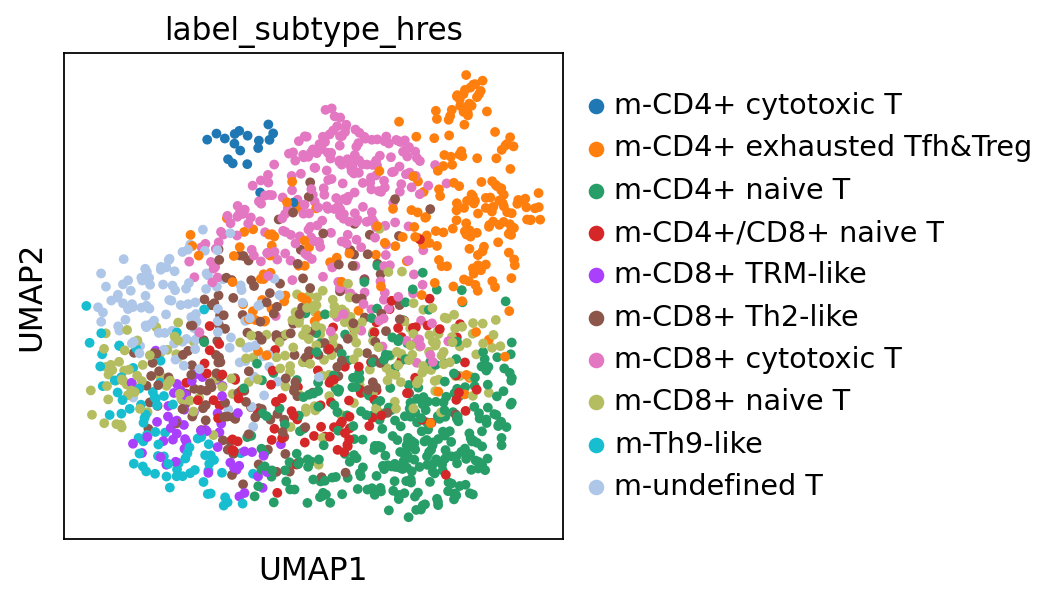

In [12]:
sc.pl.umap(adata_T, color=['label_subtype_hres'])

In [14]:
adata_T

AnnData object with n_obs × n_vars = 1548 × 4908
    obs: 'Barcode', 'Biological replicate', 'Library', 'Most_likely_Immgen_cell_type', 'Major_cell_type', 'Minor_subset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'label_singleR', 'leiden', 'lymphoid', 'label_rough', 'T', 'label_subtype', 'label_subtype_hres'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Biological replicate_colors', 'Library_colors', 'Major_cell_type_colors', 'Minor_subset_colors', 'hvg', 'label_singleR_colors', 'label_subtype_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'label_subtype_hres_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
# markers for cell lineages
marker_genes_dict_1 = {
    'CD4': ['Cd4','Il7r'],
    'CD8': ['Cd8a','Cd8b1'],
    'naive markers': ['Tcf7','Sell','Lef1','Ccr7'],
    'TEM/TRM':['Ccr5'],
    'exhausted/inhbitory': ['Lag3','Tigit','Pdcd1','Havcr2','Ctla4'],
    'cytotoxic/effector': ['Il2','Gzma','Prf1','Gzmb','Gzmk','Ifng','Nkg7'],
    'Treg': ['Il2ra','Foxp3','Ikzf2'],
    'Tfh': ['Maf','Pdcd1'],
    'Th2':['Il4','Il13'],
    'Th9':['Il9','Il10']
}

categories: 0, 1, 2, etc.
var_group_labels: CD4, CD8, naive markers, etc.


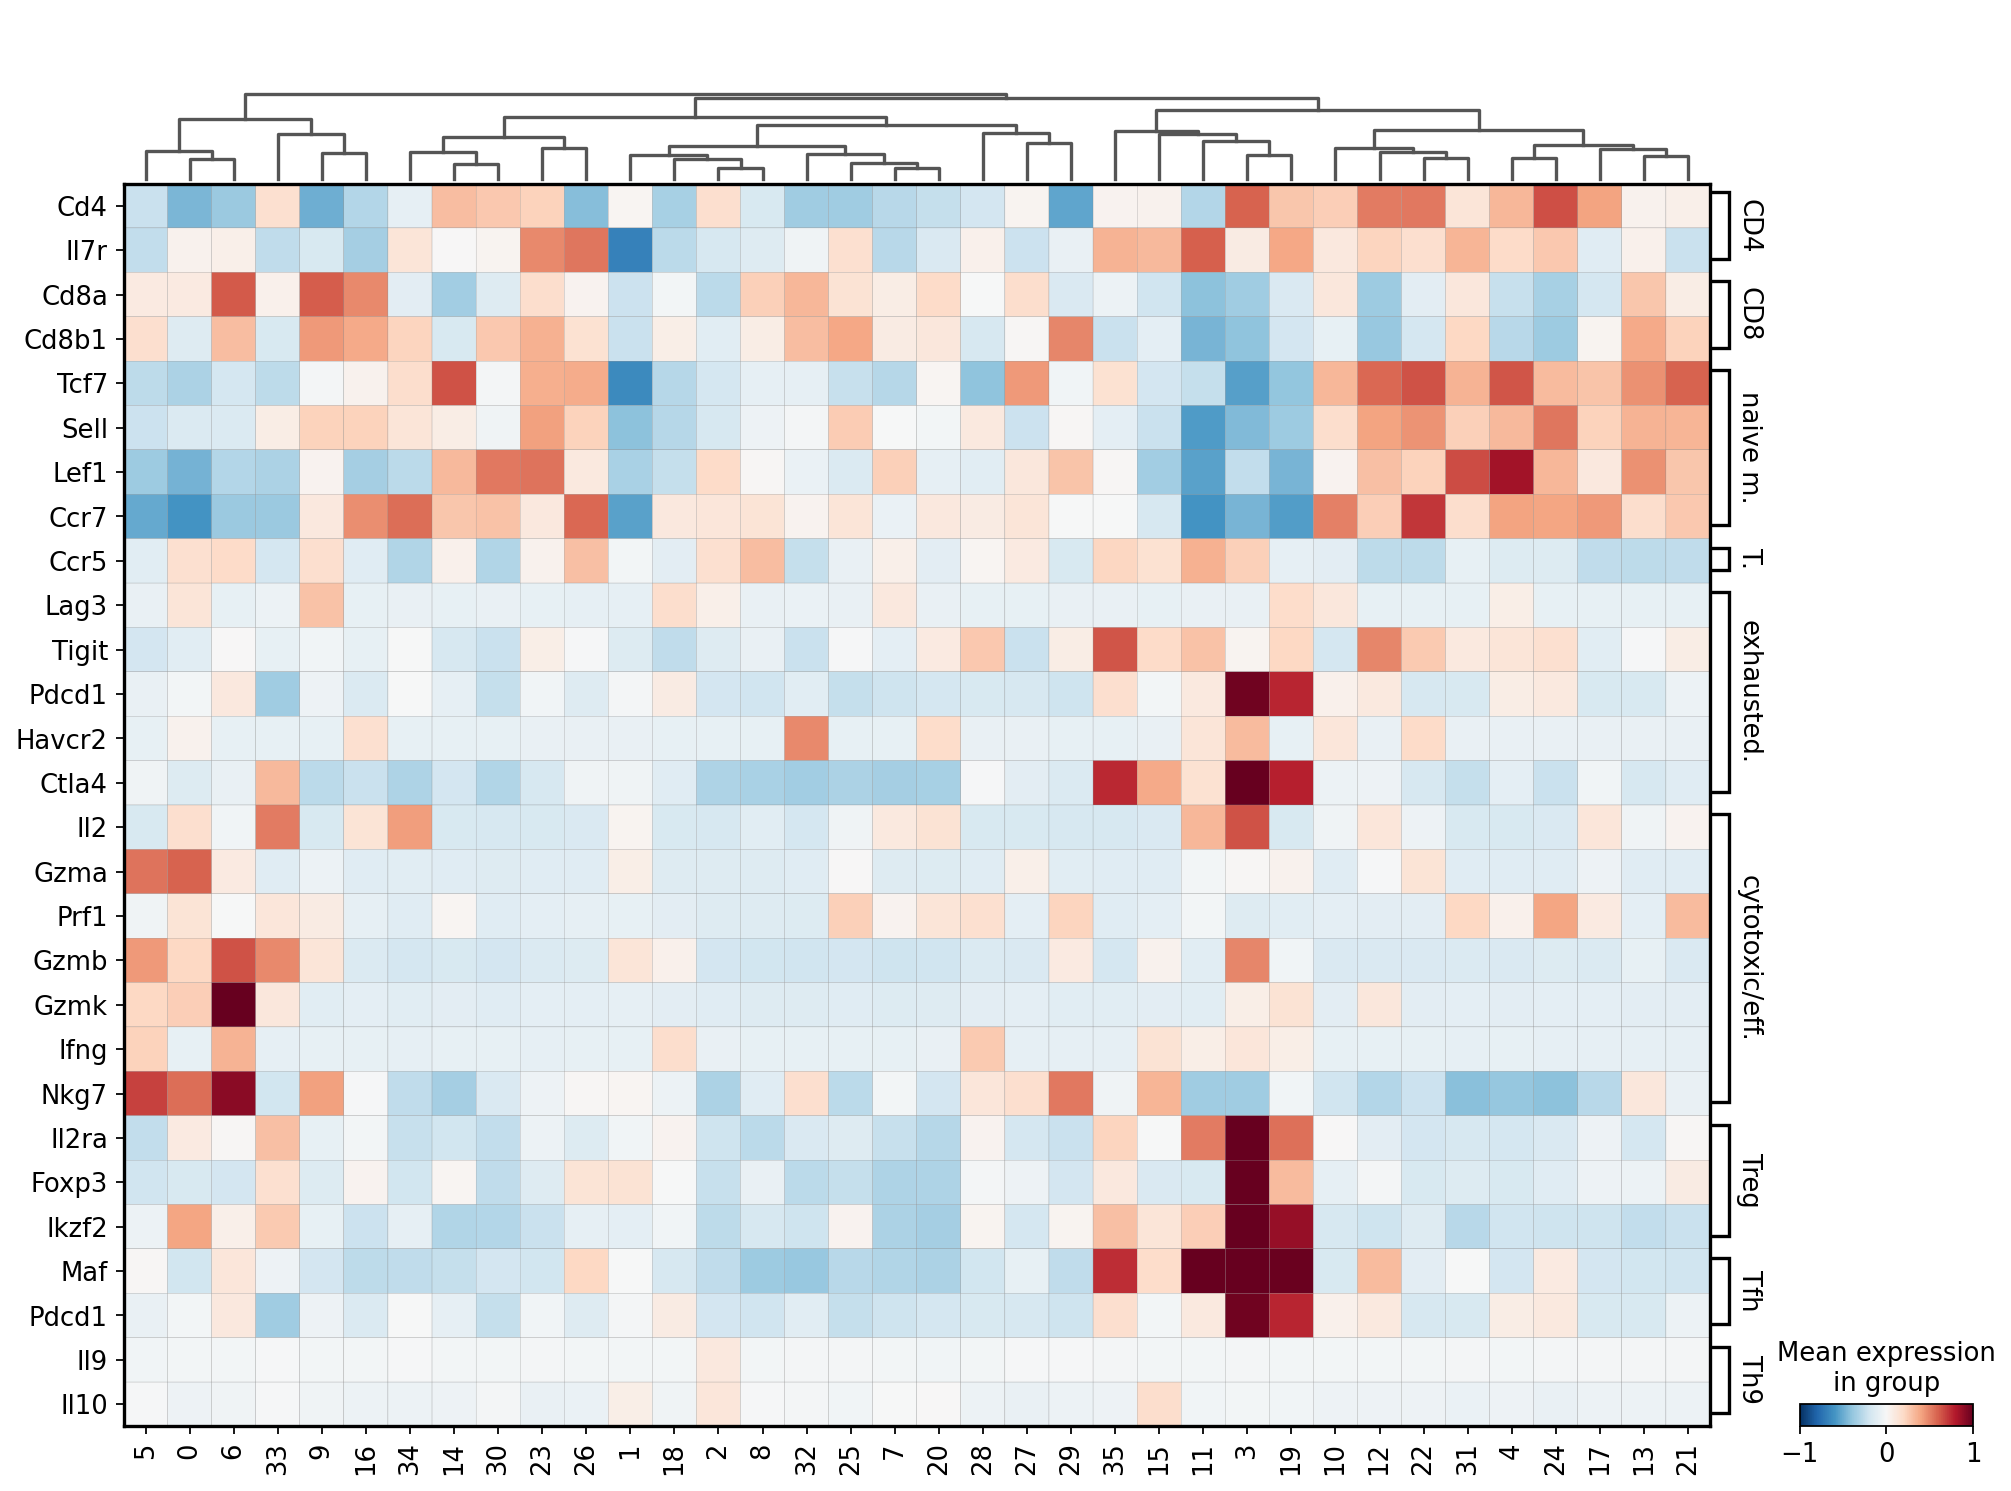

In [6]:
## matrixplot of normalized data
sc.pl.matrixplot(adata, var_names=marker_genes_dict_1,groupby='leiden', dendrogram=True, use_raw=False,swap_axes=True,cmap='RdBu_r', vmax=1, vmin=-1)

In [8]:
# create a dictionary to map cluster to subtype annotation label
cluster2annotation = {
    '0': 'm-CD8+ cytotoxic T',
    '1': 'm-undefined T', 
    '2':'m-Th9-like',
    '3':'m-CD4+ exhausted Tfh&Treg',
    '4': 'm-CD4+ naive T',
    '5':'m-CD8+ cytotoxic T',
    '6':'m-CD8+ cytotoxic T',
    '7':'m-CD8+ naive T',
    '8':'m-CD8+ TRM-like',
    '9':'m-CD8+ cytotoxic T',
    '10':'m-CD4+ naive T',
    '11':'m-CD4+ exhausted Tfh&Treg',
    '12':'m-CD4+ naive T',
    '13':'m-CD8+ naive T',
    '14':'m-CD4+ naive T',
    '15':'m-CD4+ exhausted Tfh&Treg',
    '16':'m-CD8+ naive T',
    '17':'m-CD4+ naive T',
    '18':'m-undefined T',
    '19':'m-CD4+ exhausted Tfh&Treg',
    '20':'m-CD8+ Th2-like',
    '21':'m-CD8+ naive T',
    '22':'m-CD4+ naive T',
    '23':'m-CD4+/CD8+ naive T',
    '24':'m-CD4+ naive T',
    '25':'m-CD8+ Th2-like',
    '26':'m-CD8+ naive T',
    '27':'m-CD8+ Th2-like',
    '28':'m-CD8+ Th2-like',
    '29':'m-CD8+ Th2-like',
    '30':'m-CD4+/CD8+ naive T',
    '31':'m-CD4+/CD8+ naive T',
    '32':'m-CD8+ Th2-like',
    '33':'m-CD4+ cytotoxic T',
    '34':'m-CD4+/CD8+ naive T',
    '35':'m-CD4+ exhausted Tfh&Treg'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['label_subtype_hres'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

categories: m-CD4+ cytotoxic T, m-CD4+ exhausted Tfh&Treg, m-CD4+ naive T, etc.
var_group_labels: CD4, CD8, naive markers, etc.


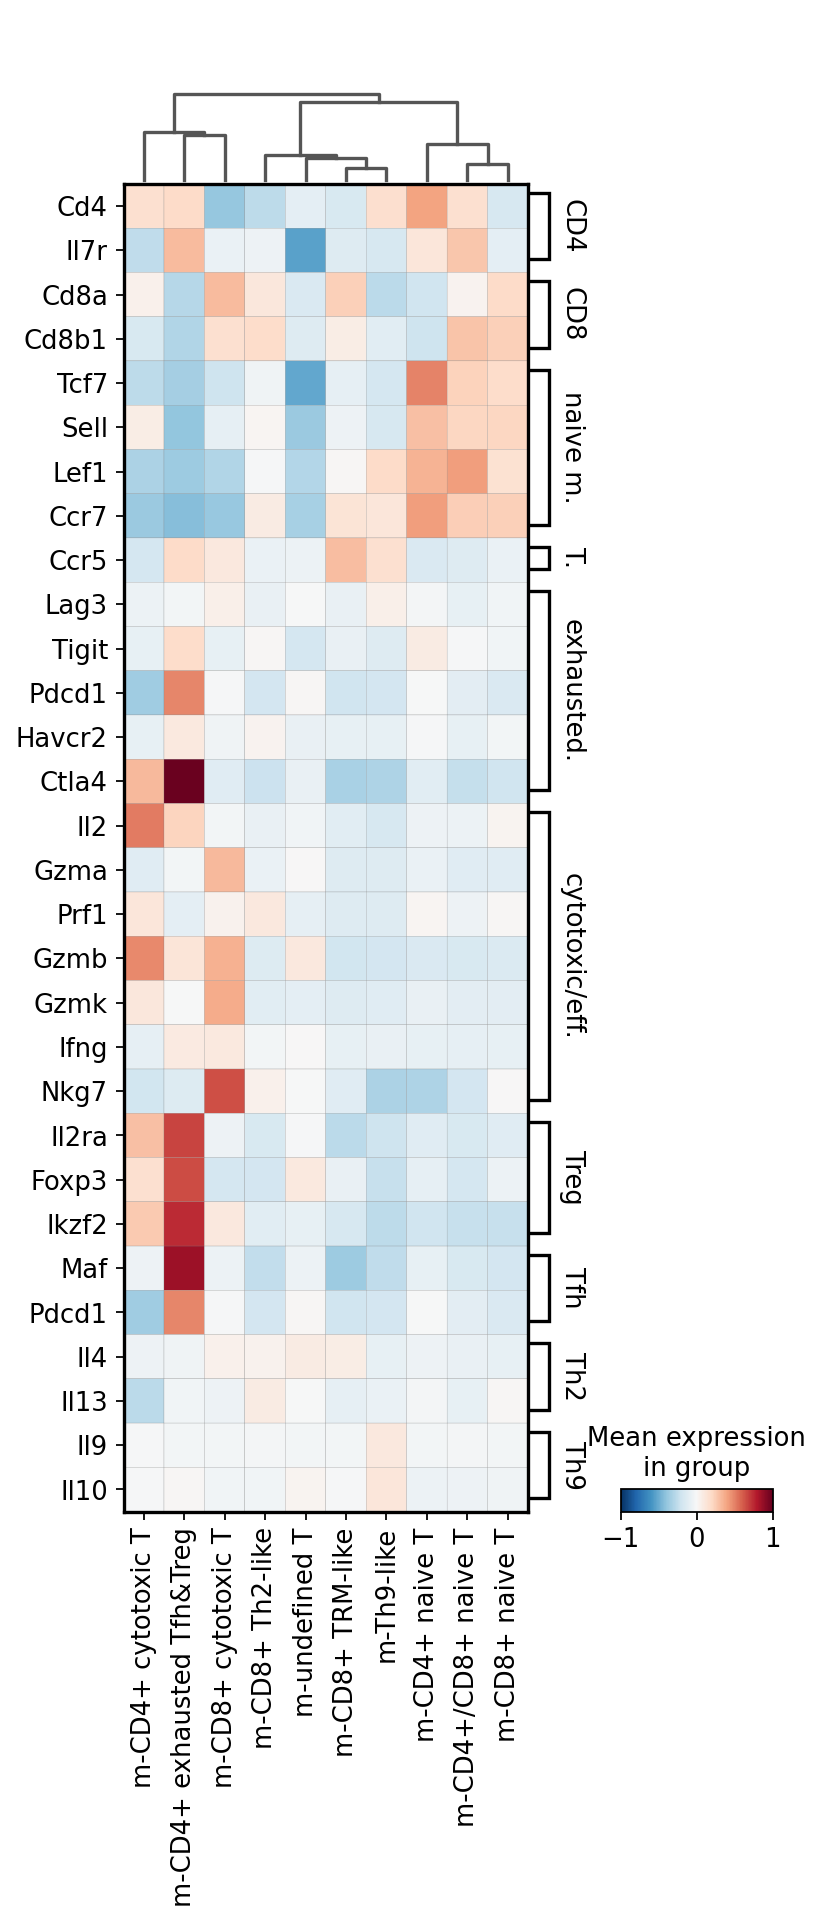

In [11]:
## matrixplot of normalized data
sc.pl.matrixplot(adata, var_names=marker_genes_dict_1,groupby='label_subtype_hres', dendrogram=True, use_raw=False,swap_axes=True,cmap='RdBu_r', vmax=1, vmin=-1)

In [7]:
## matrixplot of normalized data
sc.pl.matrixplot(adata, var_names=marker_genes_dict_1,groupby='label_subtype_hres', dendrogram=True, use_raw=False,swap_axes=True,cmap='RdBu_r', vmax=1, vmin=-1)

ValueError: groupby has to be a valid observation. Given label_subtype_hres, is not in observations: ['batch_key', 'batch_key_raw', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label_singleR', 'Most likely Immgen cell type', 'Major cell type', 'Minor subset', 'Library', 'Biological replicate', 'leiden', 'lymphoid', 'label_rough', 'T']

In [15]:
adata_T.write(T_file_v2) # mt, ribosomal, cell-cycle genes removed
#adata.write(T_file_v3) # normalized and scaled expression for visualization

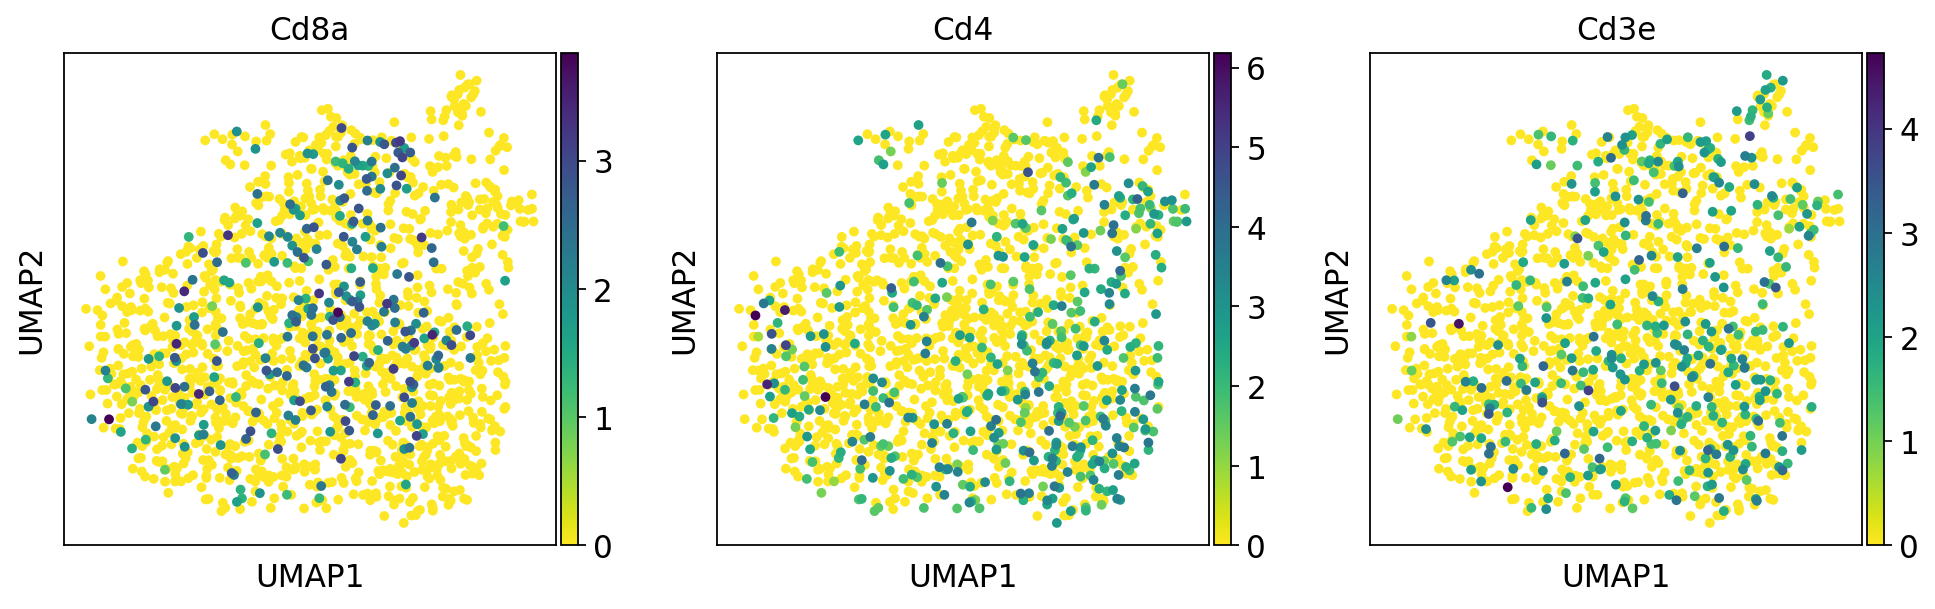

In [78]:
# differentiate NK, CD4+ T, CD8+ T
sc.pl.umap(adata_T, color=['Cd8a','Cd4','Cd3e'])

In [21]:
#import scanpy.api as sc
import matplotlib.pyplot as plt
import seaborn as sns
def get_cluster_proportions(adata,
                            cluster_key="cluster_final",
                            sample_key="replicate",
                            drop_values=None):
    """
    Input
    =====
    adata : AnnData object
    cluster_key : key of `adata.obs` storing cluster info
    sample_key : key of `adata.obs` storing sample/replicate info
    drop_values : list/iterable of possible values of `sample_key` that you don't want
    
    Returns
    =======
    pd.DataFrame with samples as the index and clusters as the columns and 0-100 floats
    as values
    """
    
    adata_tmp = adata.copy()
    sizes = adata_tmp.obs.groupby([cluster_key, sample_key]).size()
    props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index() 
    props = props.pivot(columns=sample_key, index=cluster_key).T
    props.index = props.index.droplevel(0)
    props.fillna(0, inplace=True)
    
    if drop_values is not None:
        for drop_value in drop_values:
            props.drop(drop_value, axis=0, inplace=True)
    return props

def plot_cluster_proportions(cluster_props, 
                             cluster_palette=None,
                             xlabel_rotation=0): 
    fig, ax = plt.subplots(dpi=300,figsize=(5,2))
    fig.patch.set_facecolor("white")
    
    cmap = None
    if cluster_palette is not None:
        cmap = sns.palettes.blend_palette(
            cluster_palette, 
            n_colors=len(cluster_palette), 
            as_cmap=True)
   
    cluster_props.plot(
        kind="bar", 
        stacked=True, 
        ax=ax, 
        legend=None, 
        colormap=cmap
    )
    
    ax.legend(bbox_to_anchor=(1.01, 1), frameon=False, title="Cluster",fontsize=8, title_fontsize=8)
    sns.despine(fig, ax)
    ax.tick_params(axis="x", rotation=xlabel_rotation)
    ax.set_xlabel(cluster_props.index.name.capitalize(),fontsize=12)
    ax.set_ylabel("Proportion",fontsize=12)
    fig.tight_layout()
    
    return fig

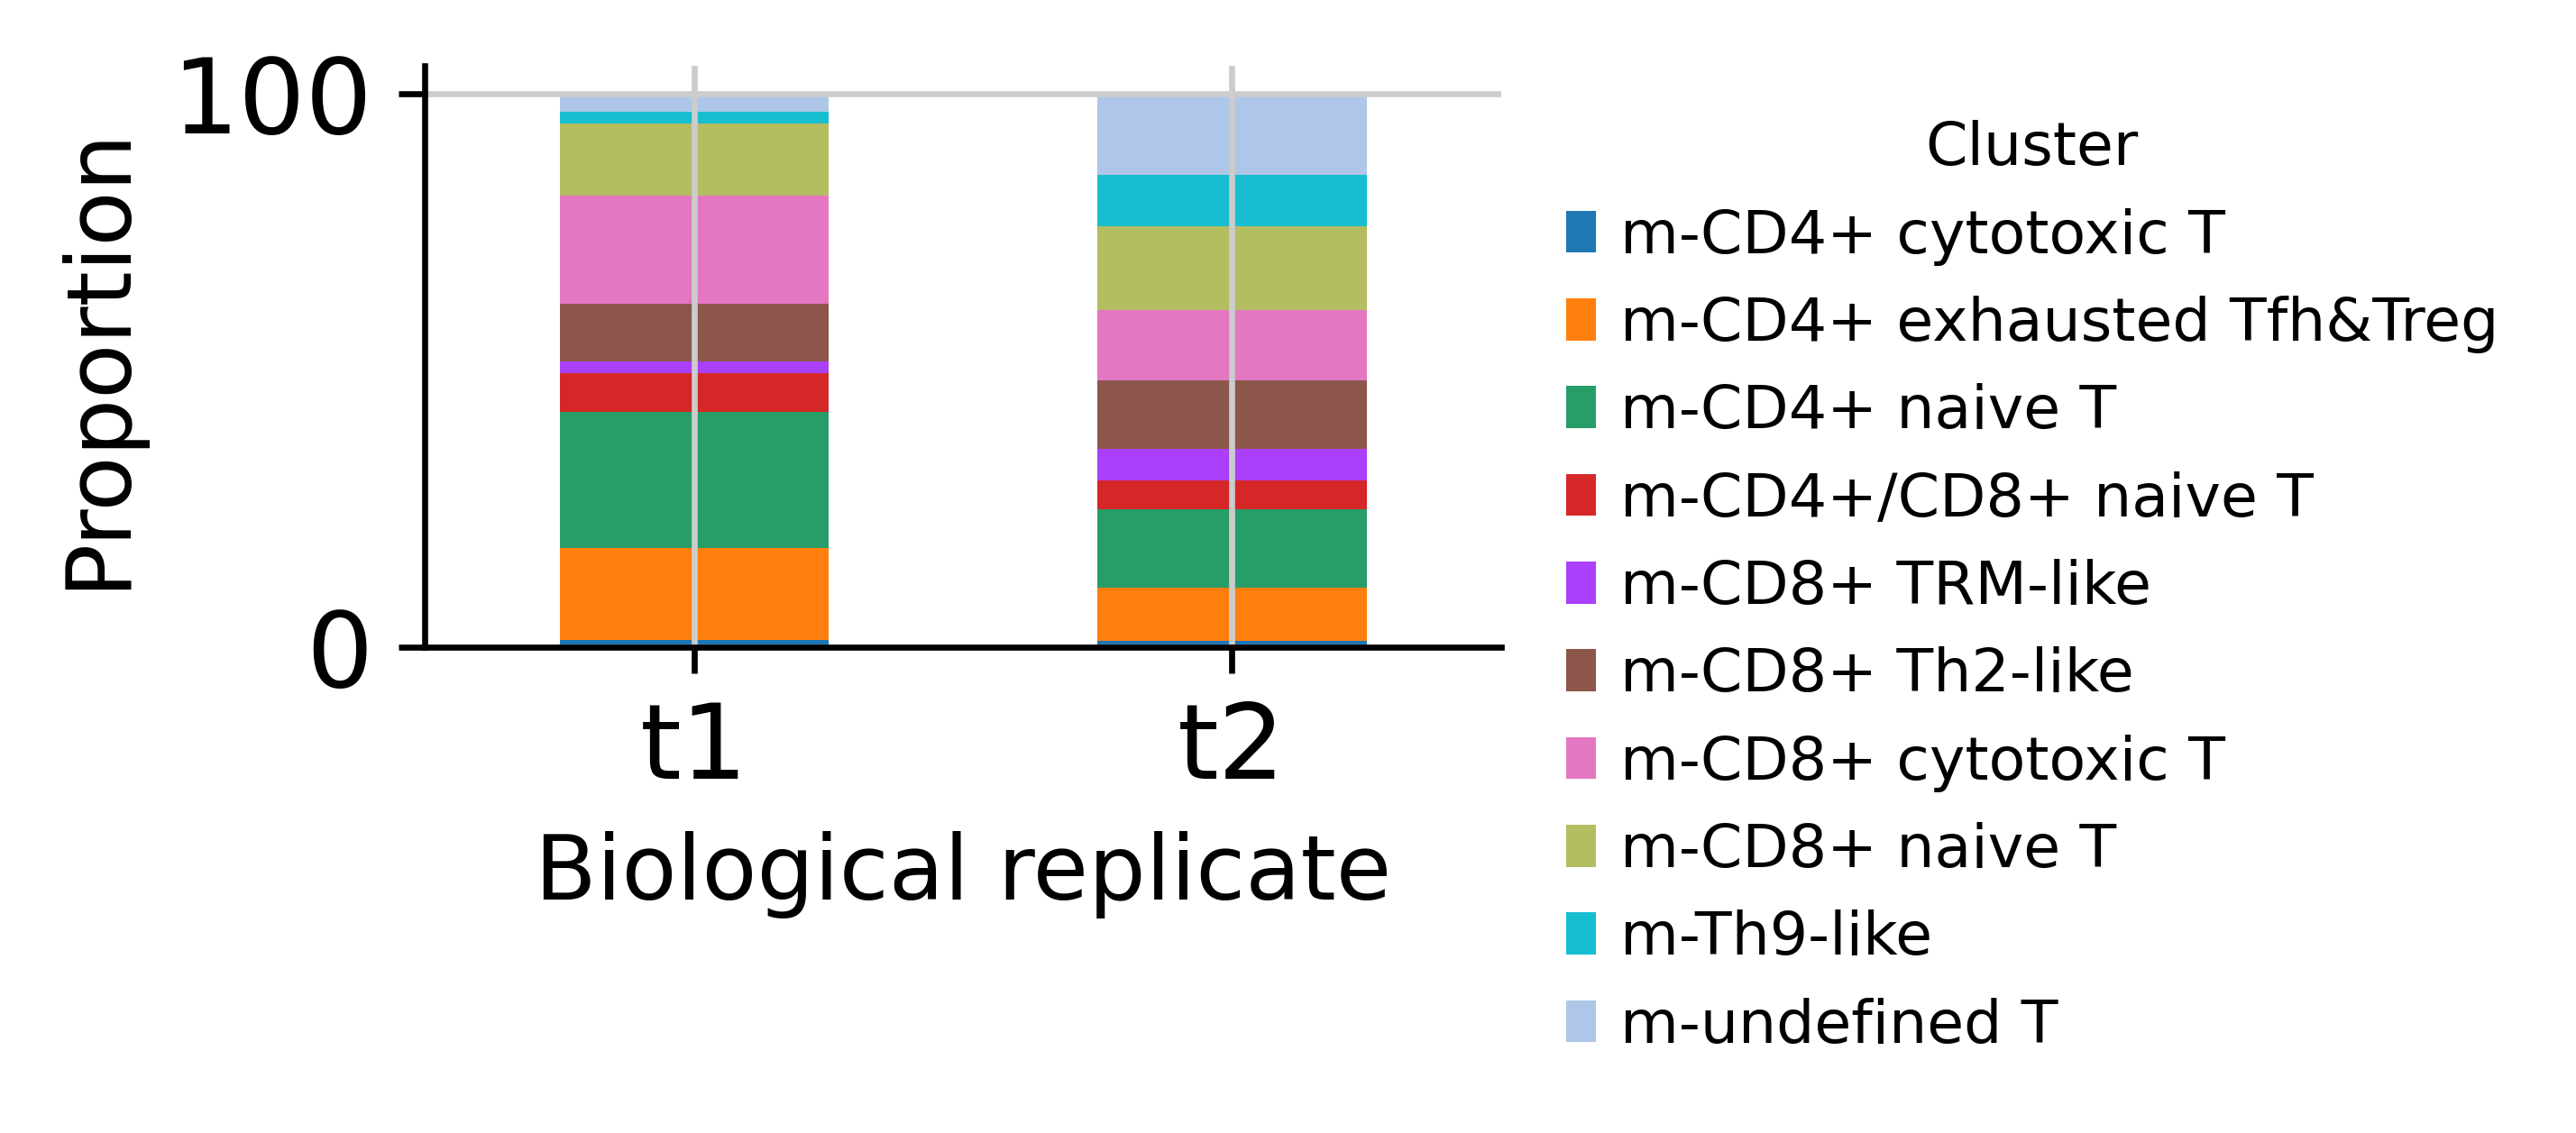

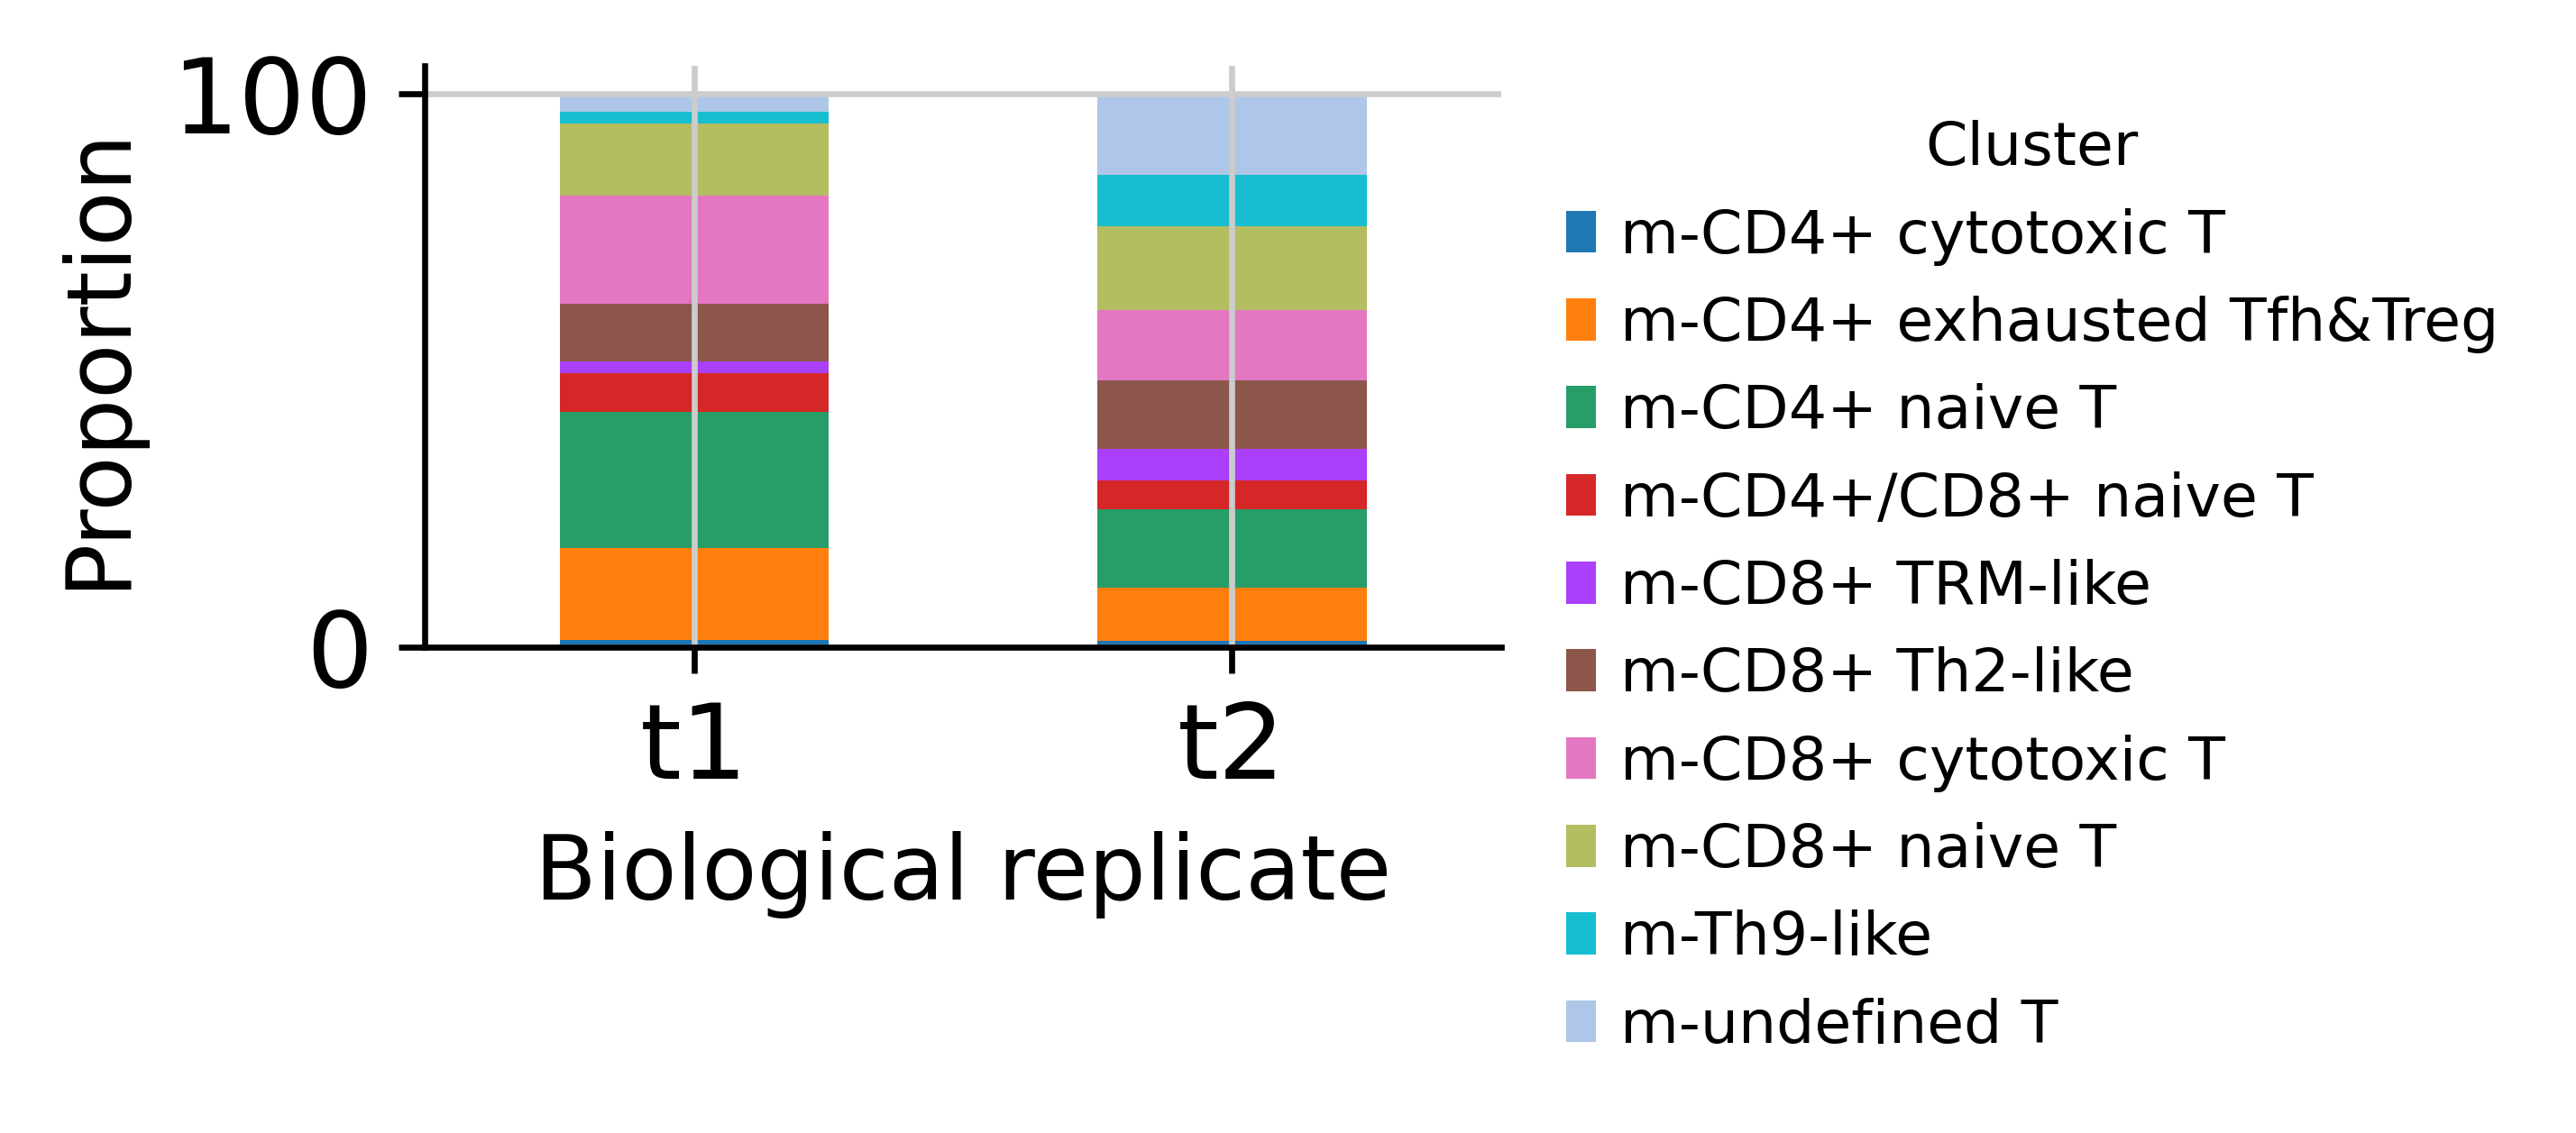

In [22]:
# leiden clusters - singleR annotation
cluster_props=get_cluster_proportions(adata_T, cluster_key='label_subtype_hres',sample_key='Biological replicate')
plot_cluster_proportions(cluster_props)

In [10]:
adata_T

AnnData object with n_obs × n_vars = 1548 × 4908
    obs: 'Barcode', 'Biological replicate', 'Library', 'Most_likely_Immgen_cell_type', 'Major_cell_type', 'Minor_subset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'label_singleR', 'leiden', 'lymphoid', 'label_rough', 'T', 'label_subtype', 'label_subtype_hres'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Biological replicate_colors', 'Library_colors', 'Major_cell_type_colors', 'Minor_subset_colors', 'hvg', 'label_singleR_colors', 'label_subtype_colors', 'label_subtype_hres_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'